# End to End Learning for Self-Driving Cars

**Paper:** Bojarski, Mariusz, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel et al. "End to end learning for self-driving cars." arXiv preprint arXiv:1604.07316 (2016).

We can improve it by doing some transformations in images.

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d zaynena/selfdriving-car-simulator
! unzip /content/selfdriving-car-simulator.zip

In [5]:
print(os.listdir("../content"))
print(os.listdir("../content/dataset/dataset"))

['.config', 'kaggle.json', 'track2data', 'dataset', 'selfdriving-car-simulator.zip', 'track1data', 'sample_data']
['driving_log.csv', 'IMG']


In [6]:
! rm '/content/dataset/dataset/IMG/Thumbs.db'

In [7]:
dataroot = "../content/dataset/dataset/"
ckptroot = "../"

In [8]:
def load_data(data_dir, train_size):
    
    data_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'),
                          names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    train_len = int(train_size * data_df.shape[0]) 
    test_len = data_df.shape[0] - train_len 
    val_len = 6000
    train_len -= val_len
    trainset, testset, valset = data.random_split(
        data_df.values.tolist(), lengths=[train_len, test_len, val_len]) # splitting for train/val/test 
                                                                        #based on sizes above
    return trainset, testset, valset

trainset, testset, valset = load_data(dataroot, train_size = 0.8)

In [9]:
def toDevice(datas, device): # sending to device to GPU
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)

In [10]:
class Dataset(Dataset):

    def __init__(self, dataroot, samples, transform=True, plot = False):
        self.samples = samples
        self.dataroot = dataroot
        self.transform = transforms.Compose([transforms.Lambda(lambda x: (x / 127.5) - 1.0)]) # normalizing [-1,1]
        self.plot = plot

    def augment(self, dataroot, imgName, angle):
  
      name = dataroot + 'IMG/' + imgName.split('\\')[-1]
      c = cv2.imread(name)
      current_image = c[65:-25, :, :] # removing front of the car
      current_image = cv2.resize(current_image, (200, 66), interpolation = cv2.INTER_AREA) # resizing to (200,66)
      current_image = cv2.cvtColor(current_image, cv2.COLOR_RGB2YUV) # changing to YUV
      if self.transform is False:
        current_image = self.transform(current_image) # normalizing

      if current_image is None:
         print('No image')

      if np.random.rand() < 0.5:
          current_image = cv2.flip(current_image, 1) # flipping image
          angle = angle * -1.0 # because of flipped
      if self.plot == True: return c, angle    

      return current_image, angle    

    def __getitem__(self, index):
        batch_samples = self.samples[index] # get batches 
        steering_angle = float(batch_samples[3])

        center_img, steering_angle_center = self.augment(self.dataroot, batch_samples[0], steering_angle)
        left_img, steering_angle_left     = self.augment(self.dataroot, batch_samples[1], steering_angle) 
        right_img, steering_angle_right   = self.augment(self.dataroot, batch_samples[2], steering_angle)

        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)

    def __len__(self):
        return len(self.samples)

In [11]:
batch_size = 128
num_workers = 16
shuffle = False
def data_loader(dataroot, trainset, valset, testset, batch_size, shuffle, num_workers, plot = False, transform = True):

    training_set = Dataset(dataroot, trainset, transform = transform, plot = plot)
    trainloader = DataLoader(training_set,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    validation_set = Dataset(dataroot, valset, transform = transform,  plot = plot)
    valloader = DataLoader(validation_set,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers)
    
    test_set = Dataset(dataroot, testset, transform = transform, plot = plot)
    testloader = DataLoader(test_set,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers)

    return trainloader, valloader, testloader

In [20]:
trainloader, validationloader, testloader = data_loader(dataroot,
                                            trainset, valset, testset,
                                            batch_size,
                                            shuffle,
                                            num_workers, 
                                            plot =True)

In [21]:
for (center, left, right) in trainloader:
  center_im, _ = center
  left_im, _ = left
  right_im, _ = right 
  break

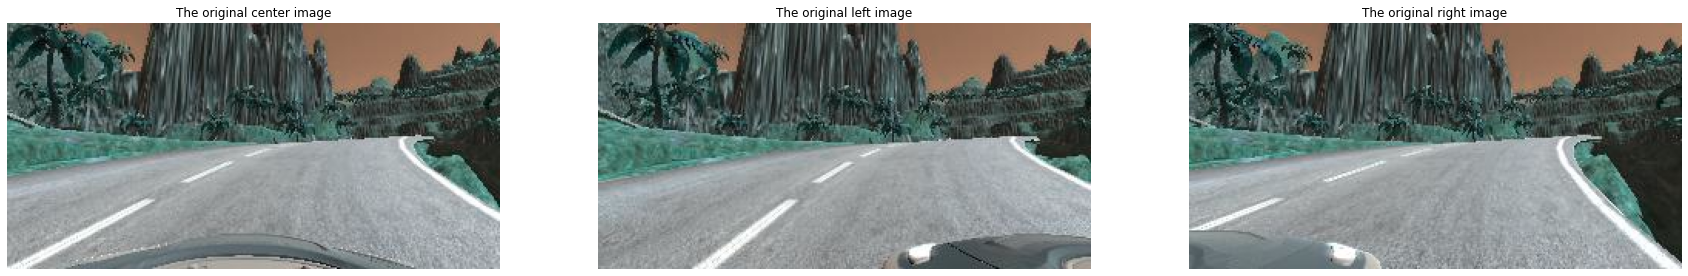

In [27]:
plt.rcParams['figure.figsize'] = (30, 30)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(center_im[85])
ax[0].axis('off')
ax[0].set_title('The original center image')
ax[1].imshow(left_im[85])
ax[1].axis('off')
ax[1].set_title('The original left image')
ax[2].imshow(right_im[85])
ax[2].axis('off')
ax[2].set_title('The original right image')
plt.show()

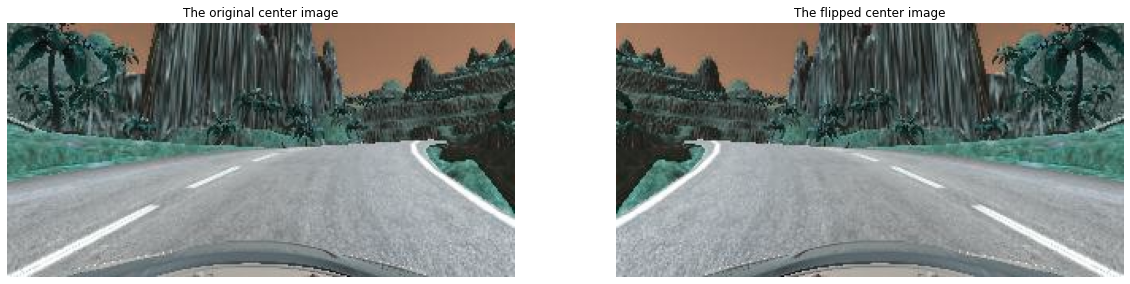

In [28]:
plt.rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(center_im[85])
ax[0].axis('off')
ax[0].set_title('The original center image')
ax[1].imshow(cv2.flip(np.array(center_im[85]), 1))
ax[1].axis('off')
ax[1].set_title('The flipped center image')
plt.show()

In [29]:
trainloader, validationloader, testloader = data_loader(dataroot,
                                            trainset, valset, testset,
                                            batch_size,
                                            shuffle,
                                            num_workers,
                                            transform = False
                                          )

In [30]:
for (center, left, right) in trainloader:
  center_im, _ = center
  left_im, _ = left
  right_im, _ = right 
  break

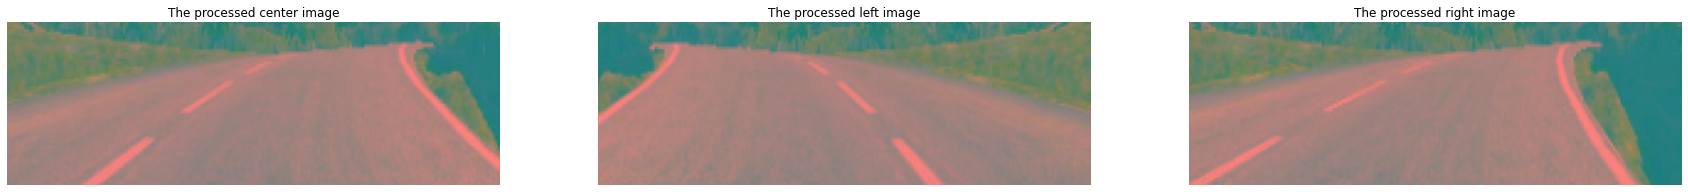

In [31]:
plt.rcParams['figure.figsize'] = (30, 30)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(center_im[85])
ax[0].axis('off')
ax[0].set_title('The processed center image')
ax[1].imshow(left_im[85])
ax[1].axis('off')
ax[1].set_title('The processed left image')
ax[2].imshow(right_im[85])
ax[2].axis('off')
ax[2].set_title('The processed right image')
plt.show()

In [32]:
shuffle = True
trainloader, validationloader, testloader = data_loader(dataroot,
                                            trainset, valset, testset,
                                            batch_size,
                                            shuffle,
                                            num_workers
                                            )

In [40]:
class ConvNet(torch.nn.Module):

  def __init__(self): # it is exactly same model in the paper, just used ReLU
    super(ConvNet, self).__init__()
      
    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 24, kernel_size = 5, stride = 2),
        nn.ReLU(),
        nn.Conv2d(24, 36, kernel_size = 5, stride = 2),
        nn.ReLU(),
        nn.Conv2d(36, 48, kernel_size = 5, stride = 2),
        nn.ReLU(),
        nn.Conv2d(48, 64, kernel_size = 3, stride = 1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
        nn.ReLU()
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(1152, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )

  def forward(self, input):

    input = input.view(input.size(0), 3, 66, 200) # shaping
    output = self.conv_layers(input)  
    output = output.view(output.size(0), -1) # flatten
    output = self.linear_layers(output)

    return output

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
metric = torch.nn.MSELoss()

cuda:0


In [55]:
model_path = './model.pth' # for saving model
dataframe_path = './'

In [56]:
dataset_dict = {
    'train': trainloader,
    'val': validationloader,
    'test': testloader
}

In [57]:
def train_model(model, dataset, metric, optimizer, epoch_size):

  epoch_number, train_losses, val_losses,  = [], [], []
  best_loss = 10000.0

  for epoch in range(epoch_size):
    epoch_number.append(epoch)           
    train_loss, val_loss  = 0.0, 0.0
    
    # Training
    model.train()

    for local_batch, (centers, lefts, rights) in enumerate(dataset['train']):
      centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)

      optimizer.zero_grad()
      datas = [centers, lefts, rights]
      for data in datas:
          imgs, angles = data
          out = model(imgs)
          loss = torch.sqrt(metric(out, angles.unsqueeze(1)) + 1e-6) # RMSE
          loss.backward()
          optimizer.step()
          train_loss += loss.data.item()
            
    # Validation
    model.eval()
    with torch.no_grad():
      for local_batch, (centers, lefts, rights) in enumerate(dataset['val']):
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        datas = [centers, lefts, rights] 
        for data in datas:  
          imgs, angles = data     
          out = model(imgs)
          loss = torch.sqrt(metric(out, angles.unsqueeze(1))+ 1e-6)
          val_loss += loss.item()

      # Average train/val losses
      train_loss = train_loss / len(dataset['train'])
      val_loss = val_loss / len(dataset['val'])


      train_losses.append(train_loss)
      val_losses.append(val_loss)

      print('Epoch {}/{}'.format(epoch, epoch_size - 1), 'Train Loss: {:.4f}'.format(train_loss), 'Val Loss: {:.4f}'.format(val_loss))
      print('-' * 50)
    

      if val_loss < best_loss: # best val loss
        torch.save(model.state_dict(), model_path) # save model
        best_loss = val_loss

   
  print('The Best val Loss: {:4f}'.format(best_loss))

  # for plotting
  dataframe = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"]) 
  dataframe["Epoch"] = epoch_number
  dataframe["Train Loss"] = train_losses
  dataframe["Test Loss"] = val_losses
  dataframe.to_csv(os.path.join(dataframe_path, "dataframe.csv"), index = False)

  return model


In [58]:
model = train_model(model, dataset_dict, metric, optimizer, 50)

Epoch 0/49 Train Loss: 1.0240 Val Loss: 0.9543
--------------------------------------------------
Epoch 1/49 Train Loss: 0.9615 Val Loss: 0.9453
--------------------------------------------------
Epoch 2/49 Train Loss: 0.9336 Val Loss: 0.9300
--------------------------------------------------
Epoch 3/49 Train Loss: 0.9090 Val Loss: 0.9043
--------------------------------------------------
Epoch 4/49 Train Loss: 0.8952 Val Loss: 0.8921
--------------------------------------------------
Epoch 5/49 Train Loss: 0.8765 Val Loss: 0.8842
--------------------------------------------------
Epoch 6/49 Train Loss: 0.8665 Val Loss: 0.8790
--------------------------------------------------
Epoch 7/49 Train Loss: 0.8540 Val Loss: 0.8948
--------------------------------------------------
Epoch 8/49 Train Loss: 0.8402 Val Loss: 0.8562
--------------------------------------------------
Epoch 9/49 Train Loss: 0.8303 Val Loss: 0.8564
--------------------------------------------------
Epoch 10/49 Train Lo

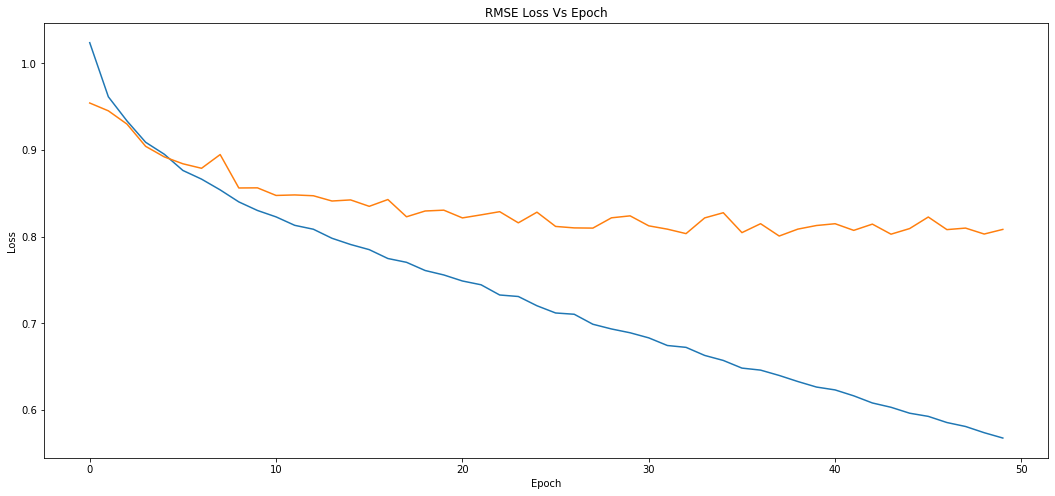

In [59]:
# basic plotting
data = genfromtxt(os.path.join(dataframe_path, "dataframe.csv"), delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])
  
plt.rcParams["figure.figsize"] = (18,8)
plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")
plt.title('RMSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
     

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [61]:
model = ConvNet()
model.load_state_dict(torch.load("/content/model.pth"))
model.to(device)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1152, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [62]:
# Testing (same as validation)
test_loss = 0.0
model.eval()
with torch.no_grad():
  for local_batch, (centers, lefts, rights) in enumerate(dataset_dict['test']):
    centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
    datas = [centers, lefts, rights] 
    for data in datas:
      imgs, angles = data 
      out = model(imgs)
      loss = torch.sqrt(metric(out, angles.unsqueeze(1))+ 1e-6)
      test_loss += loss.item()
test_loss = test_loss / len(dataset_dict['test']) 
print(f'RMSE for Test Dataset: "{test_loss}"')

RMSE for Test Dataset: "0.8060217432531656"
